# CNN
This notebook aims to deploy the CNN.

## Setup for UCloud
The Setup on Ucloud is a bit feasty at times, so here are some workarounds

In [45]:
#pip freeze > requirements.txt

In [46]:
!pip install -r requirements.txt
!pip install matplotlib opencv-python pandas scikit-learn tensorflow
!pip install numpy==1.26.4 --force-reinstall
!pip install editdistance

# scipy
!pip install --upgrade --force-reinstall --no-cache-dir scipy
!pip install --upgrade --force-reinstall --no-cache-dir scikit-learn


Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-2.1.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.1.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3
Defaulting to user installation because normal site-packages is not writea

In [47]:
!sudo apt-get update 
!sudo apt-get -y upgrade
!sudo apt-get install -y libgl1

Hit:1 http://security.ubuntu.com/ubuntu noble-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu noble InRelease
Hit:3 http://archive.ubuntu.com/ubuntu noble-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu noble-backports InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Calculating upgrade... Done
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1 is already the newest version (1.7.0-1build1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [48]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from editdistance import eval as edit_distance  

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.backend import ctc_decode



---
## Loading the data
Data has to load out of the 'carolianminuscule-groundtruth'-folder 

In [49]:
def get_images(folder_path: str):
    """
    Load images and text files from the given path.
    :param folder_path: Path to the directory containing images and text files.
    :return: Two lists - one for image paths and one for text file paths.
    """
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"Path {folder_path} does not exist.")

    images = []
    files = []

    for entry in os.listdir(folder_path):
        entry_path = os.path.join(folder_path, entry)
        if os.path.isdir(entry_path):
            # Recursively get images and text files from subdirectories
            sub_images, sub_files = get_images(entry_path)
            images.extend(sub_images)
            files.extend(sub_files)
        elif entry.endswith(".png"):
            images.append(entry_path)
        elif entry.endswith(".txt"):
            files.append(entry_path)

    return images, files


# load the data from the directory
path = "carolineminuscule-groundtruth"
images, files = get_images(path)


# matched the .png- and .txt-file in a folder together
matched_list_path = [
    [img, file]
    for img in images
    for file in files
    if os.path.dirname(img) == os.path.dirname(file)
    and os.path.splitext(os.path.splitext(os.path.basename(img))[0])[0]
    == os.path.splitext(os.path.splitext(os.path.basename(file))[0])[0]
]


In [50]:
print(f"len matched: {len(matched_list_path)}")
print(f"matched_list:\n {matched_list_path[1]}")

len matched: 429
matched_list:
 ['carolineminuscule-groundtruth/bsb00054504/0016/010018.bin.png', 'carolineminuscule-groundtruth/bsb00054504/0016/010018.gt.txt']


---
## Creating the Dataset

In [51]:
# define a dataframe to store the image, image paths and their corresponding text files
df = pd.DataFrame(columns=["name", "image", "transcription"])

for i, (img_path, file_path) in enumerate(matched_list_path):
    # read the image
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    img = np.array(img)
    # add the image to the dataframe, set "none" here to add transcription later
    df.loc[i] = [os.path.basename(img_path), img, None]
    # read the text file
    with open(file_path, "r") as f:
        # read the transcription
        transcription = f.read()
    # add the transcription to the dataframe
    df.loc[i, "transcription"] = transcription

In [52]:
# delete all the linebrakes in the transcription
df["transcription"] = df["transcription"].str.replace("\n", "", regex=False)
df.head(5)

,name,image,transcription
0,010017.bin.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",tato more aduenientes repedaret amortuis . Et ...
1,010018.bin.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",iret unde descenderat atq; indm* rediret '? De...
2,010016.bin.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",Sedet mortis modũ quo dehacuita disce deret ? ...
3,010008.bin.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",tuti prudentioris docilis humana mens et socia...
4,010003.bin.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",ora precepta atq; honestatis etiustite conscia...


For now it appear that the images only have "255" as values, i.e. white. That's why im checking for other values. But the edges of the images are all white, therefore this is the exspected behaviour.

In [53]:
non_255_values = df['image'].apply(lambda img: np.any(img != 255))
print(f"Rows  in 'image' with values other than 255: {non_255_values.sum()}")

Rows  in 'image' with values other than 255: 429


---
## Preparing the data

By calculating the maximum and avg. number of the height we can use that value later in our CNN.

In [54]:
# Calculate the maximum and average length of the lists in the 'image' column
image_heigth = df['image'].apply(lambda img: img.shape[0])  # Get the height of each image array
max_length = image_heigth.max()
avg_length = image_heigth.mean()

print(f"Maximum height of an image: {max_length}")
print(f"Average height of an image: {int(avg_length)}")


# Calculate the maximum and average length of the lists in the 'image' column
image_lengths = df['image'].apply(lambda img: img.shape[1])  # Get the height of each image array
max_length = image_lengths.max()
avg_length = image_lengths.mean()

print(f"Maximum length of an image: {int(max_length)}")
print(f"Average length of an image: {int(avg_length)}")

Maximum height of an image: 263
Average height of an image: 140
Maximum length of an image: 3058
Average length of an image: 1938


Getting the number of unique character, servs here more as an exploration into the the datas.
We stand at a pathway here: Either we manually map each of the 83 characters by hand to the according representative in the images or, use the CNN-RNN architecture. Which does not need manual character mapping, but is harder to train.

In [55]:
# Features (images) and labels (transcriptions)
X = df["image"].values  # Images as NumPy arrays
y = df["transcription"].values  # Transcriptions as strings

In [56]:
# # Convert images to NumPy arrays and normalize
X = np.array(
    [cv2.resize(img, (1024, 256)) for img in df["image"]], dtype=np.float32
)  # Resize and convert to float32

print(f"X shape: {X.shape}, dtype: {X.dtype}")

X shape: (429, 256, 1024), dtype: float32


In [57]:
# find the length of the transcription
# aplly different measures

transcription_lengths = df["transcription"].apply(len)
print(f"Max length:\t\t {int(transcription_lengths.max())}")
print(f"Mean length:\t\t {int(transcription_lengths.mean())}")
print(f"Median length:\t\t {int(transcription_lengths.median())}")

Max length:		 70
Mean length:		 46
Median length:		 48


In [58]:
# Convert transcriptions to sequences of integers
label_sequences = [
    [char_to_index[char] for char in transcription]
    for transcription in df["transcription"]
]

# Pad sequences to a fixed length (use a value outside the valid character indices, like num_classes - 1 for blank)
max_sequence_length = 256
padded_labels = pad_sequences(
    label_sequences, maxlen=max_sequence_length, padding="post", value=num_classes - 1
)

# y should be the padded integer sequences
y = np.array(padded_labels, dtype=np.int32) # Use int32 for labels

print(f"y shape: {y.shape}, dtype: {y.dtype}")

# Split data (y will now be integer sequences)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"y_train shape: {y_train.shape}, dtype: {y_train.dtype}")

y shape: (429, 256), dtype: int32
y_train shape: (343, 256), dtype: int32


In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

num_classes = len(charset) + 1  # Number of unique characters

In [60]:
print(f"X_train shape: {X_train.shape}, dtype: {X_train.dtype}")
print(f"y_train shape: {y_train.shape}, dtype: {y_train.dtype}")

X_train shape: (343, 256, 1024), dtype: float32
y_train shape: (343, 256), dtype: int32


---
## Data visualisation
Below I want to gain a better understanding of our datapoints

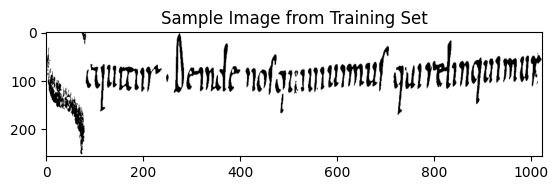

In [61]:
plt.imshow(X_train[10], cmap="gray", vmin=0, vmax=255)
plt.title("Sample Image from Training Set")
plt.show()

In [62]:
print("First entry in y_train:")
print(y_train[10])

First entry in y_train:
[27 36 46 50 40 49 50 47  5  0 14 36 40 43 35 36  0 43 44 48  0 46 50 40
 50 40 50 40 42 50 48  0 46 50 40  0 47 36 41 40 43 46 50 40 42 50 48 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83]


---
The 'cnn_rnn'-model is comprised of an
- input layer
  - where images are read into with 64px, None and one channel
- A convolutional layer which is building 64, 3x3-filters
- Maxpooling to reduce parametersize

In [63]:
cnn_rnn = models.Sequential(
    [
        # CNN layers
        layers.Conv2D(
            64, (3, 3), padding="same", activation="relu", input_shape=(256, 1024, 1)
        ),
        layers.MaxPooling2D(pool_size=(2, 2)),  # → (128, 512, 64)
        layers.Conv2D(128, (3, 3), padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),  # → (64, 256, 128)
        # Reshape for RNN
        layers.Reshape(target_shape=(256, 64 * 128)),  # → (batch, 256, 8192)
        # RNN layers
        layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
        # Output layer
        layers.Dense(num_classes, activation="softmax")  # Use softmax for probabilities
    ]
)

def ctc_loss(y_true, y_pred):
    input_length = tf.ones(shape=(tf.shape(y_pred)[0],), dtype=tf.int32) * tf.shape(y_pred)[1]
    label_length = tf.ones(shape=(tf.shape(y_true)[0],), dtype=tf.int32) * tf.shape(y_true)[1]
    return tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)



cnn_rnn.compile(optimizer="adam", loss=ctc_loss)

#cnn_rnn.summary()


/home/ucloud/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [64]:
#! Commented out to avoid running the model training
# # Fit the model
cnn_rnn.fit(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_test, y_test),
)

Epoch 1/10


IndexError: tuple index out of range

In [ ]:
# Vorhersagen erzeugen
y_pred = cnn_rnn.predict(X_test)  # Shape: (batch_size, time_steps, num_classes)

# Greedy decoding
decoded, _ = ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0]) * y_pred.shape[1])


# In Text umwandeln
def decode_to_text(seq):
    return "".join(index_to_char.get(i, "") for i in seq if i < len(index_to_char))


y_pred_texts = [decode_to_text(seq.numpy()) for seq in decoded[0]]
y_true_texts = [
    "".join(
        [index_to_char[i] for i in np.argmax(label, axis=1) if i < len(index_to_char)]
    )
    for label in y_test
]

# Character Error Rate (CER)
total_chars = sum(len(t) for t in y_true_texts)
total_errors = sum(edit_distance(p, t) for p, t in zip(y_pred_texts, y_true_texts))
cer = total_errors / total_chars
print(f"Character Error Rate (CER): {cer:.2%}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
Character Error Rate (CER): 131.66%


In [ ]:
cnn_rnn.save("./Run_models/CNN_RNN_model.keras")

FileNotFoundError: [Errno 2] No such file or directory: './Run_models/CNN_RNN_model.keras'

In [ ]:
# # Load the model
# loaded_model = load_model("Run_models/20250519/20250519_CNN_RNN_model/")
# loaded_model.summary()


# # Select an image from the test set
# sample_image = X_test[0]

# # Reshape the image to match the input shape of the model
# sample_image_reshaped = sample_image.reshape(1, 256, 1024, 1)

# # Get the model's prediction
# prediction = loaded_model.predict(sample_image_reshaped)

# decoded_sequences, _ = tf.keras.backend.ctc_decode(
#     prediction, input_length=np.ones(prediction.shape[0]) * prediction.shape[1]
# )
# predicted_text = "".join(
#     index_to_char[idx]
#     for idx in decoded_sequences[0][0].numpy()
#     if idx < num_classes - 1
# )

# # Decode the prediction
# predicted_sequence = np.argmax(prediction, axis=-1)[0]
# predicted_text = "".join(
#     index_to_char[idx] for idx in predicted_sequence if idx < num_classes - 1
# )

# print("Predicted transcription:")
# print(predicted_text)